# ESO ATMO 2021 Tutorial: Chemistry and Clouds in Exoplanet Transit Spectroscopy

What you will learn:

1. What happens to the transiting spectra (emission and transmission) of planet atmospheres as they cool?
2. What is happening from a chemical standpoint to cause these spectral features? 
3. What molecules are good temperature probes in transit transmission? in emission?  

What you should know from Dr. Ryan MacDonald's lecture: 

1. Transmission + emission spectra geometry (which atmospheric regions are we probing etc.)
2. Simple toy models of transmission and emission spectra.
3. The radiative transfer equation.
4. Solutions to radiative transfer equation (focus on intuition for differences between transmission and emission solutions)
5. Concept of optical depth.

**Installation:**

Option 1 - Google Colab:
1. Make a copy of this installation [Google Colab (requires ~6 Gb of free google drive space)](https://colab.research.google.com/drive/1QdLwzS2p6RO_JwYUWcjizlpiTlRF3bB-?usp=sharing) in your Google Drive. Follow the instructions, you will only have to run this installation notebook once!
2. Make a copy of [this Colab in your Google drive](https://drive.google.com/file/d/1-PckjZ_OkfDAuKtnnp7B6P7IpDIX_XIQ/view?usp=sharing) and follow along! 

Option 2 - Personal Computer:
- Install via the [installation instructions on PICASO](https://natashabatalha.github.io/picaso/installation.html) (requires ~6 Gb of free hard drive space)
- Download this notebook and run locally! 

In [1]:
import warnings
warnings.filterwarnings(action='ignore')
import picaso.justdoit as jdi
import picaso.justplotit as jpi
jpi.output_notebook()
import os
import pandas as pd
import numpy as np
#point to your sonora profile grid that you untared (see installation instructions or colab instructions)
sonora_profile_db = '/Users/nbatalh1/Documents/data/sonora_profile/'
mieff_dir = '/Users/nbatalh1/Documents/data/virga/'

Loading BokehJS ...

In [2]:
wave_range = [1,14] #don't worry we will play around with this more later
opa = jdi.opannection(wave_range=wave_range)

## What happens to a transit (transmission+emission) spectrum as a function of temperature

We will dive right in by computing a series of spectra as a function of temperature. As we progress we will break down what is happening. 

### What is the relevant temperature range we care about for exoplanets?

In [3]:
all_planets = jdi.all_planets()

In [4]:
#let's only grab targets with masses and errors
pl_mass_err = all_planets.loc[:,['pl_name','pl_letter','pl_bmassjerr1', 'pl_bmassj','pl_eqt']]
pl_mass_err = pl_mass_err.dropna()

In [5]:
fig = jpi.figure(x_axis_type='log',x_axis_label='Mass(Mj)',y_axis_label='Eql Temp (A=0)')
source = jpi.ColumnDataSource(data=dict(
        pl_mass_err))
cir = fig.circle(x='pl_bmassj',y='pl_eqt',size=5,
                   color='Black', source = source)
fig.add_tools(jpi.HoverTool(renderers=[cir], tooltips=[('Planet Name',f'@pl_name')]
                                  ))
jpi.show(fig)

For this tutorial we will focus on the region from T_eq = 100-2500 K. However, as you can see there do exist planets outside this range! Let's take a feasible subset of these. I will choose ten planets across this temperature range. 

In [6]:
T_to_compute = np.arange(100,2500,250)

Let's run PICASO in a loop with the different effective temperatures and gravities. However, in order to aid comparison, let's fix the following quantities:

1. star 
2. gravity

Then in the loop we will change: 

1. pressure-temperature profile 
2. chemistry (in accordance with the changing temperature-pressure profile) 

Both these properties will be computed via the `sonora` function, which will grab Solar M/H, Solar C/O self consistent pressure-temperature profiles in accordance with the work from Marley et al. 2021. 

In [7]:
case = jdi.inputs()
case.star(opa, 5000,0,4.0,radius=1, radius_unit=jdi.u.Unit('R_sun'))
case.gravity(radius = 1, radius_unit=jdi.u.Unit('R_jup'), 
           mass = 1, mass_unit=jdi.u.Unit('M_jup'))

Running this loop should take roughly 2 minutes

In [8]:
#Let's stick the loop in right here!
all_out={} #easy mechanism to save all the output
for i in T_to_compute:
    case.sonora(sonora_profile_db,  i)
    all_out[f'{i}'] = case.spectrum(opa,calculation='thermal+transmission', full_output=True)

Let's plot the sequence!!

In [9]:
wno,spec=[],[]
fig_e = jpi.figure(height=300,width=700, y_axis_type='log',
                 x_axis_label='Wavelength(um)',y_axis_label='Relative Planet/Star Flux (ppm)')
fig_t = jpi.figure(height=300,width=700, 
                 x_axis_label='Wavelength(um)',y_axis_label='Transit Depth (ppm)')

for i,ikey in enumerate(all_out.keys()):
    x,y = jdi.mean_regrid(all_out[ikey]['wavenumber'],
                          all_out[ikey]['thermal'], R=150)
    fig_e.line(1e4/x,y*1e6,color=jpi.Spectral11[i],line_width=3,
               legend_label=f'Teff={ikey}')

    x,y = jdi.mean_regrid(all_out[ikey]['wavenumber'],
                          all_out[ikey]['transit_depth'], R=150)
    fig_t.line(1e4/x,y*1e6,color=jpi.Spectral11[i],line_width=3)
    
fig_e.legend.location='bottom_right'
    
jpi.show(jpi.column([fig_t, fig_e]))

There is rich information encoded in these spectra. In order to fully grasp what is going on, it is important to understand the chemistry.

## What molecules are most important to planetary spectroscopy?

When we compute our spectra, we get a full output of abundances (aka "mixing ratios") as a function of pressure. 

In [10]:
#remember the mixing ratios (or abundances) exist in this pandas dataframe 
all_out['100']['full_output']['layer']['mixingratios'].head()
#but this is too many molecules to keep track of for every single spectrum

,H2,H,H+,H-,H2-,H2+,H3+,He,H2O,CH4,...,C2H6,SiO,MgH,OCS,Li,LiOH,LiH,LiCl,Al,CaH
0,0.836890,4.505502e-38,4.505502e-38,4.505502e-38,4.505502e-38,4.505502e-38,4.505502e-38,0.16265,1.525707e-25,0.000466,...,4.505502e-38,4.505502e-38,4.505502e-38,4.505502e-38,4.505502e-38,4.505502e-38,4.505502e-38,4.505502e-38,5.294763e-57,5.294763e-57
1,0.836890,4.505500e-38,4.505500e-38,4.505500e-38,4.505500e-38,4.505500e-38,4.505500e-38,0.16265,3.485631e-25,0.000466,...,4.505500e-38,4.505500e-38,4.505500e-38,4.505500e-38,4.505500e-38,4.505500e-38,4.505500e-38,4.505500e-38,4.513556e-57,4.513556e-57
2,0.836889,4.505500e-38,4.505500e-38,4.505500e-38,4.505500e-38,4.505500e-38,4.505500e-38,0.16265,1.004419e-24,0.000466,...,4.505500e-38,4.505500e-38,4.505500e-38,4.505500e-38,4.505500e-38,4.505500e-38,4.505500e-38,4.505500e-38,3.861181e-57,3.861181e-57
3,0.836889,4.505500e-38,4.505500e-38,4.505500e-38,4.505500e-38,4.505500e-38,4.505500e-38,0.16265,3.443305e-24,0.000466,...,4.505500e-38,4.505500e-38,4.505500e-38,4.505500e-38,4.505500e-38,4.505500e-38,4.505500e-38,4.505500e-38,3.311096e-57,3.311096e-57
4,0.836888,4.505500e-38,4.505500e-38,4.505500e-38,4.505500e-38,4.505500e-38,4.505500e-38,0.16265,1.487465e-23,0.000466,...,4.505500e-38,4.505500e-38,4.505500e-38,4.505500e-38,4.505500e-38,4.505500e-38,4.505500e-38,4.505500e-38,2.847291e-57,2.847291e-57


But we want to understand the transitions in chemistry between these runs. To do that, let's try and understand how the bulk abundance change as a function of effective temperature. So we are going to **collapse** the pressure axis by taking the "median" value of each abundance array. By doing so, we want to see what the ~10 most abundant molecules are in each of these 10 spectra.

In [11]:
relevant_molecules=[]
for i,ikey in enumerate(all_out.keys()):
    abundances = all_out[ikey]['full_output']['layer']['mixingratios']
    
    #first let's get the top 10 most abundance species in each model bundle we ran
    median_top_10 = abundances.median().sort_values(ascending=False)[0:10]
    relevant_molecules += list(median_top_10.keys())

#taking the unique of  relevant_molecules will give us the molecules we want to track 
relevant_molecules = np.unique(relevant_molecules)

print(relevant_molecules)

['Al' 'C2H6' 'CH4' 'CO' 'CO2' 'Fe' 'H' 'H2' 'H2O' 'H2S' 'He' 'K' 'N2'
 'NH3' 'Na' 'SiO']


Now that we have condensed this to a meaningful set of molecules, we can proceed to plot the sequence 


*Side note: You might try to see if the technique of taking the "median" yields the same results as "max" or "mean". This gives some insight into how dynamic moleculare abundances are as a function of pressure*

## Where in temperature space do chemical transitions seem to take place? 

In [12]:
fig = jpi.figure(height=500,width=700, y_axis_type='log',
                 y_range=[1e-15,1],x_range=[200,2600],
                 x_axis_label='Planet Effective Temperature',y_axis_label='Abundance')

#now let's go back through our models and plot the abundances as a function of teff
relevant_molecules={i:[] for i in relevant_molecules}
for i,ikey in enumerate(all_out.keys()):
    abundances = all_out[ikey]['full_output']['layer']['mixingratios'].median()

    #save each abundance 
    for i in relevant_molecules.keys():
        relevant_molecules[i] += [abundances[i]]

#last loop to plot each line
for i,ikey in enumerate( relevant_molecules.keys()):
    fig.line(T_to_compute, relevant_molecules[ikey],
               color=jpi.Category20[20][i],line_width=3,legend_label=ikey) 
fig.legend.location='bottom_right'
jpi.show(fig)

There is a lot happening but let's break it down in very broad digestible categories.

#### Universally abundant molecules:
- Which are the few highest abundance molecules/elements that exist across all temperature? 

#### Carbon-bearing species (CO2, CH4, CO, C2H6):
- Which molecules are good temperature indicators, meaning they only exist in certain temperature regimes?
- For the molecules that are good temperature indicators, where do their transitions occur? Keep these numbers archived in the back of your brain as they are great to have for intuition

#### Besides Carbon, what other non-metal-based molecules are dominant?
- Are any of them indicators of high or low temperature?
- Do any of them exhibit an interplay that is similar to that of the CH4/CO transition?

#### What Alkali-based molecules/elements are dominant?
- At what temperatures do these molecules/elements begin to appear? 

#### What Metal-based species are dominant?
- At what temperatures do these molecules/elements begin to appear? 

#### DISCUSS: 
- Across all these molecules, what are the few most critical temperature transitions? 
- What known phenomena can cause deviations from chemical equilibrium? 

## Is this molecule affecting my spectrum? 

Seeing a high abundance for a molecule does not automatically mean that it will be detectable in a given spectrum. In order to determine if a molecule is detectable we need to further address these questions: 

1. Do you have sufficient spectral resolution to resolve the full spectral feature? 
2. Does it have a visible spectral feature in the wavelength range I am observing? 
3. Are there other molecules with higher opacity interfering with it's contribution at similar wavelengths? 

**In order to address these questions, use the `jdi.get_contribution` function on at least three different temperature regimes that seem important above.** The output of the contribution function consists of three important items: 

`taus_per_layer`
- Each dictionary entry is a nlayer x nwave that represents the per layer optical depth for that molecule. 

`cumsum_taus`
- Each dictionary entry is a nlevel x nwave that represents the cumulative summed opacity for that molecule. 

`tau_p_surface` 
- Each dictionary entry is a nwave array that represents the pressure level where the cumulative opacity reaches the value specified by the user through `at_tau`.

Below is one example using the extreme ends T=400 and T=2000. 

In [13]:
case1 = jdi.inputs()
case1.star(opa, 5000,0,4.0,radius=1, radius_unit=jdi.u.Unit('R_sun'))
case1.gravity(radius = 1, radius_unit=jdi.u.Unit('R_jup'), 
           mass = 1, mass_unit=jdi.u.Unit('M_jup'))
case1.phase_angle(0)
case1.sonora(sonora_profile_db, 400)
out1 = jdi.get_contribution(case1, opa, at_tau=1)

In [14]:
case2 = jdi.inputs()
case2.star(opa, 5000,0,4.0,radius=1, radius_unit=jdi.u.Unit('R_sun'))
case2.gravity(radius = 1, radius_unit=jdi.u.Unit('R_jup'), 
           mass = 1, mass_unit=jdi.u.Unit('M_jup'))
case2.phase_angle(0)
case2.sonora(sonora_profile_db, 2000)
out2 = jdi.get_contribution(case2, opa, at_tau=1)

Plot the $\tau\sim1$ surface

In [15]:
figs=[]
for i,it in zip([out1['tau_p_surface'], out2['tau_p_surface']],['Cold','Hot']):
    wno=[]
    spec=[]
    labels=[]
    for j in i.keys(): 
        x,y = jdi.mean_regrid(opa.wno, i[j],R=100)
        if np.min(y)<4.5: # Bars 
            wno+=[x]
            spec+=[y]
            labels +=[j]
    fig = jpi.spectrum(wno,spec,plot_width=500,plot_height=400,y_axis_label='Tau~1 Pressure (bars)',
                       y_axis_type='log',x_range=[1,14],
                         y_range=[1e2,1e-4],legend=labels)
    fig.title.text=it
    figs+=[fig]
jpi.show(jpi.row(figs))

Let's think through these main points:

1. Is there a difference between the continuum species? Does that make sense given your intuition of the temperature pressure profiles? 
2. How has the interplay of H2O/CO2/CH4/CO changed between the two models?
3. Can you spot any molecules that appeared in relatively high abundance in the mixing ratio plots, but do not appear here? 

**Repeat the Exercise: Swap out your T=2000 K case with a T=1000 K case.**
1. We know that CH4/CO should be experience a big chemical shift in this region. Isolate the Tau~1 curve for CH4. What accounts for the difference in contribution curve? 

## Understanding Models in the Context of Observing Modes

Now that we have an intuition for diagnosing spectra. Let's gain an intuition for what molecules dominate what spectral regions. I find it is best to do this with real instrument modes. Let's focus on JWST modes. Take a moment to stare at the figure below:

![JWST Modes](https://natashabatalha.github.io/assets/img/gallery/pec_res.jpg)



**Discussion**: 
1. What spectral features are dominant across what JWST modes? For different planet cases? 
    - NIRISS SOSS:
    - NIRCam F322W2: 
    - NIRCam F444W: 
    - NIRSpec G140: 
    - NIRSpec G235:
    - NIRSpec G395: 
    - NIRSpec Prism:$^*$
    - MIRI LRS


*$^*$what is the sublety that makes this a difficult mode to use universally*

2. Excluding the Prism, if you had to choose only one mode for JWST to observe the cold planet case, which would you choose? Repeat for hot planet case. 
3. Are there regions of parameter space where two molecule overlap could be problematic? 

## Adding Clouds to the Story using `Virga`

Since you've already had some experience modeling clouds in spectra, we will focus on specific cloud profiles and cloud species. We have already computed some cloud-free models. Let's add clouds to the models we have already computed. 

There are a few more parameters that we have to specify with regards to the cloud code: 

- metallicity and mean molecular weight (should be consistent with your atmosphere profile) 
- f$_{sed}$: sedimentation efficiency, which controls the vertical extent of the cloud deck. For more information see: https://natashabatalha.github.io/virga/notebooks/1_GettingStarted.html#How-to-pick-f_{sed}
- K$_{zz}$: vertical mixing 
- Gas condensates: in general, you should think carefully about what gases you want to set as condensable. For this exercise we will just look at a subset four potential condensates for simplicity. 

In [16]:
case_cld = jdi.inputs()
case_cld.star(opa, 5000,0,4.0,radius=1, radius_unit=jdi.u.Unit('R_sun'))
case_cld.gravity(radius = 1, radius_unit=jdi.u.Unit('R_jup'), 
           mass = 1, mass_unit=jdi.u.Unit('M_jup'))

#Let's stick the loop in right here!
cld_mdl_out={} #easy mechanism to save all the output
all_out_cld={}
for i in T_to_compute:
    case_cld.sonora(sonora_profile_db,  i)
    
    p=case_cld.inputs['atmosphere']['profile']['pressure']
    t=case_cld.inputs['atmosphere']['profile']['temperature']
    
    #NEW CLOUD STUFF
    metallicity = 1 #1xSolar 
    mean_molecular_weight = 2.2
    fsed=1
    gas_condensates = ['H2O','KCl','Mg2SiO4','Al2O3']

    #for the cloud code we have to supply a kzz value, which describes the degree of mixing 
    case_cld.inputs['atmosphere']['profile']['kz'] = [1e9]*len(p)
    
    cld_mdl_out[f'{i}'] = case_cld.virga(gas_condensates, mieff_dir, fsed=fsed,mh=metallicity,
                 mmw = mean_molecular_weight,full_output=True)
    all_out_cld[f'{i}'] = case_cld.spectrum(opa,calculation='thermal+transmission', full_output=True)

### A cloud sequence in transit emission 

In [17]:
wno,spec=[],[]
fig = jpi.figure(height=500,width=500, y_axis_type='log',
                 x_axis_label='Wavelength(um)',y_axis_label='Flux (erg/s/cm2/cm)')
delta_fig = jpi.figure(height=500,width=500, #y_axis_type='log',
                 x_axis_label='Wavelength(um)',y_axis_label='% Diff Cloud Free - Cloudy')
#CLOUD FREE
for i,ikey in enumerate(all_out_cld.keys()):
    x,y1 = jdi.mean_regrid(all_out[ikey]['wavenumber'],
                          all_out[ikey]['thermal'], R=150)
    
    a=fig.line(1e4/x,y1,color=jpi.Spectral11[i],line_width=3,
               alpha=0.75, line_dash='dashed',legend_label='cloud free')

    #CLOUDYyY
    x,y2 = jdi.mean_regrid(all_out_cld[ikey]['wavenumber'],
                          all_out_cld[ikey]['thermal'], R=150)
    a=fig.line(1e4/x,y2,color=jpi.Spectral11[i],line_width=3,
               legend_label='cloudy')

    delta_fig.line(1e4/x,100*(y1-y2)/y1,color=jpi.Spectral11[i],line_width=3)

fig.legend.location='bottom_right'
    
jpi.show(jpi.row(fig,delta_fig))

What overall affect do the clouds have on emission spectra? 

### A cloud sequence in transit transmission 

In [18]:
wno,spec=[],[]
fig = jpi.figure(height=500,width=500, y_axis_type='log',
                 x_axis_label='Wavelength(um)',y_axis_label='Relative Transit Depth')
delta_fig = jpi.figure(height=500,width=500, #y_axis_type='log',
                 x_axis_label='Wavelength(um)',y_axis_label='% Diff Cloud Free - Cloudy')
#CLOUD FREE
for i,ikey in enumerate(all_out_cld.keys()):
    x,y1 = jdi.mean_regrid(all_out[ikey]['wavenumber'],
                          all_out[ikey]['transit_depth'], R=150)
    
    a=fig.line(1e4/x,y1,color=jpi.Spectral11[i],line_width=3,
               alpha=0.75, line_dash='dashed',legend_label='cloud free')

    #CLOUDYyY
    x,y2 = jdi.mean_regrid(all_out_cld[ikey]['wavenumber'],
                          all_out_cld[ikey]['transit_depth'], R=150)
    a=fig.line(1e4/x,y2,color=jpi.Spectral11[i],line_width=3,
               legend_label='cloudy')

    delta_fig.line(1e4/x,100*(y1-y2)/y1,color=jpi.Spectral11[i],line_width=3)

fig.legend.location='bottom_right'
    
jpi.show(jpi.row(fig,delta_fig))

What overall affect do the clouds have on transmission spectra? 

### What is the dominant cloud species for each case? 

We saved all of the cloud output in the dictionary `cld_mdl_out`. You can explore all the output fields here: https://natashabatalha.github.io/virga/notebooks/2_RunningTheCode.html#Exploring-dict-Output

In [19]:
cld_mdl_out['100'].keys()

dict_keys(['pressure', 'pressure_unit', 'temperature', 'temperature_unit', 'wave', 'wave_unit', 'condensate_mmr', 'cond_plus_gas_mmr', 'mean_particle_r', 'droplet_eff_r', 'r_units', 'column_density', 'column_density_unit', 'opd_per_layer', 'single_scattering', 'asymmetry', 'opd_by_gas', 'condensibles', 'scalar_inputs', 'fsed', 'altitude', 'layer_thickness', 'z_unit', 'mixing_length', 'mixing_length_unit', 'kz', 'kz_unit', 'scale_height', 'cloud_deck'])

In [20]:
import virga
jpi.show(virga.justplotit.opd_by_gas(cld_mdl_out['100']))

Since we are interested in the full sequence of optical depths, let's pull out these optical depth plots for a few of the cases. 

In [21]:
figs = []

for i,ikey in enumerate(list(all_out_cld.keys())[::3]):
    
    figs += [virga.justplotit.opd_by_gas(cld_mdl_out[ikey], 
                                         title=f'Teff={ikey}K',plot_width=300)]
    
    figs[i].legend.location='bottom_left'


jpi.show(jpi.row(figs))

It can be easily seen why the hot spectra are drastically altered by the cloud profile. Plot the PT profile with the condensation curves to see where Mg2SiO4 is condensing. 

In [22]:
jpi.show(virga.justplotit.pt(cld_mdl_out['1600'], plot_height=500))

In addition to the contribution plots we made above, below is a simple heat map plotting function that will plot the opacity of the molecule and the opacity of the cloud. 

**Step through a few of the cases to understand the interplay between the gas and the cloud opacity.**

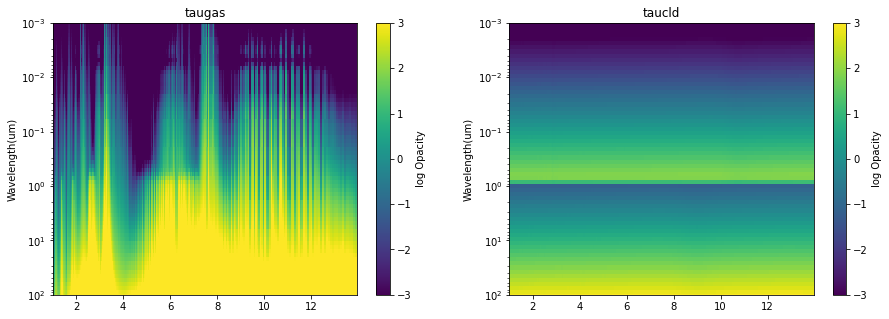

In [23]:
import matplotlib.pyplot as plt
fig, ax = plt.subplots(ncols=2,figsize=(15,5))

ikey = '100'

for it, itau in enumerate(['taugas','taucld']):

    tau_bin = []
    for i in range(all_out_cld[ikey]['full_output'][itau].shape[0]):
        x,y = jdi.mean_regrid(all_out_cld[ikey]['wavenumber'],
                              all_out_cld[ikey]['full_output'][itau][i,:,0], R=150)
        tau_bin += [[y]]

    tau_bin = np.array(np.log10(tau_bin))[:,0,:]
    X,Y = np.meshgrid(1e4/x,all_out_cld[ikey]['full_output']['layer']['pressure'])
    Z = tau_bin
    pcm=ax[it].pcolormesh(X, Y, Z)
    cbar=fig.colorbar(pcm, ax=ax[it])
    pcm.set_clim(-3.0, 3.0)
    ax[it].set_title(itau)
    ax[it].set_yscale('log')
    ax[it].set_ylim([1e2,1e-3])
    ax[it].set_ylabel('Pressure(bars)')
    ax[it].set_ylabel('Wavelength(um)')
    cbar.set_label('log Opacity')

**Final Discussion**: 
- Revisit the JWST questions. Would you change any of your "mode selections" based on the affect you see here with clouds? 
- What might be some observational strategies to combat muting of spectral features ? 